# Data Project

> **Note:** 
> 1. This is a starting point for how to structure your data project 
> 1. The `dataproject.py` file includes functions which can be in this notebook

Import and set magics:

In [5]:
#!pip install numpy
#!pip install matplotlib
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install fredapi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# APIs
from fredapi import Fred
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

# user written modules
import dataproject


In [3]:
data = dataproject.load_data()
data = dataproject.process_data(data)

<h2 style="color:red">Vi mangler også at tilføje tekst</h2>

## 1 Aggregate inflation in Denmark

## 1.1 Basics

We load the data from ....

In [6]:
# We can access data from the DST API as follows:
PRIS113 = DstApi('PRIS113')
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [5]:
#a. Set download parameters
params_PRIS113 = {
    'table': 'PRIS113',
    'format': 'BULK', # semicolon separated file
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},
        {'code': 'Tid', 'values': ['*']}, # '' is everything
        ]
    }

CPI = PRIS113.get_data(params=params_PRIS113)
CPI['date'] = pd.to_datetime(CPI['TID'], format='%YM%m')
CPI['INDHOLD'] = CPI['INDHOLD'].astype(float)
CPI = CPI.drop(columns=['TYPE', 'TID'])
CPI = CPI.rename(columns={'INDHOLD': 'index'})
CPI = CPI.set_index('date').sort_index()

# 1. The CPI indexed to 100 on average in 2020
CPI['index'] = CPI['index']/CPI.loc[CPI.index.year == 2020, 'index'].mean() * 100

# 2. month-to-month inflation rate
CPI['pi_month'] = CPI['index'].pct_change()*100

# 3. 12-month inflation rate
CPI['pi_year'] = CPI['index'].pct_change(12, fill_method=None)*100

CPI

,index,pi_month,pi_year
date,,,
1980-01-01,31.904608,NaN,NaN
1980-02-01,32.194650,0.909091,NaN
1980-03-01,32.678053,1.501502,NaN
1980-04-01,32.871415,0.591716,NaN
1980-05-01,33.354818,1.470588,NaN
...,...,...,...
2025-05-01,116.403481,0.083126,1.603376
2025-06-01,116.693522,0.249169,1.856540
2025-07-01,118.433774,1.491301,2.253756


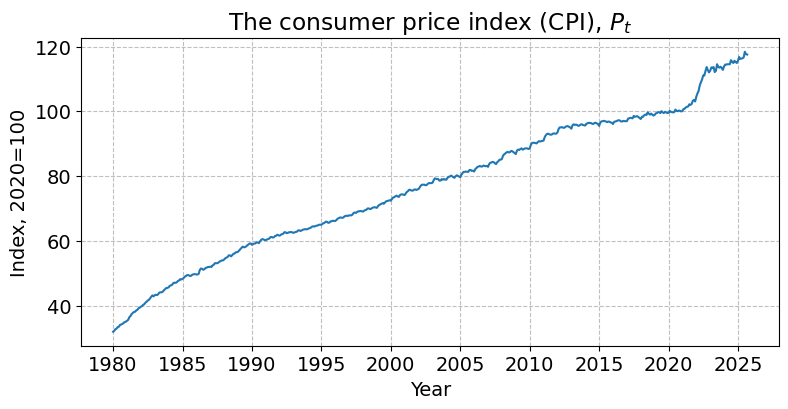

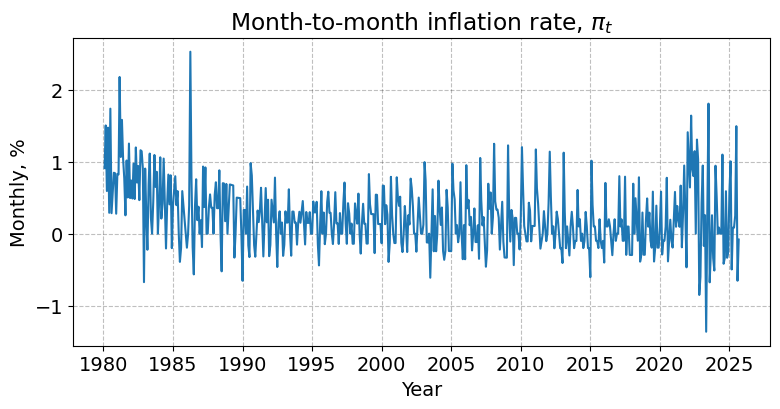

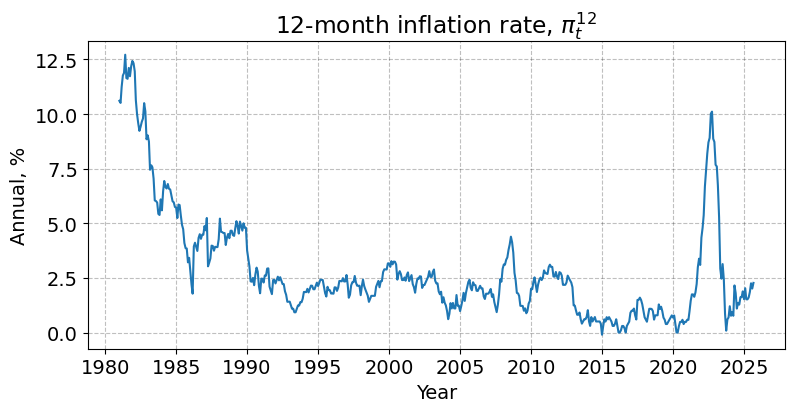

In [6]:
cols = ["index", "pi_month", "pi_year"]

titles = {
    "index": "The consumer price index (CPI), $P_t$",
    "pi_month": "Month-to-month inflation rate, $\pi_t$",
    "pi_year": "12‑month inflation rate, $\pi_{t}^{12}$"
}

ylabels = {
    "index": "Index, 2020=100",
    "pi_month": "Monthly, %",
    "pi_year": "Annual, %"
}

for i, col in enumerate(cols):
    fig, ax = plt.subplots(figsize=(9,4))
    ax.plot(CPI.index, CPI[col])
    ax.set_title(titles.get(col, col))
    ax.set_xlabel('Year')
    ax.set_ylabel(ylabels.get(col, col))
    # if col in ylims:
    #     ax.set_ylim(ylims[col])
    plt.show()

## 1.2  Instantaneous inflation

We process the data by ...

/var/folders/jg/t273kmdx66j20_cgz521t6d40000gn/T/ipykernel_80785/1368195693.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum((T-j)**alpha for j in range(T))


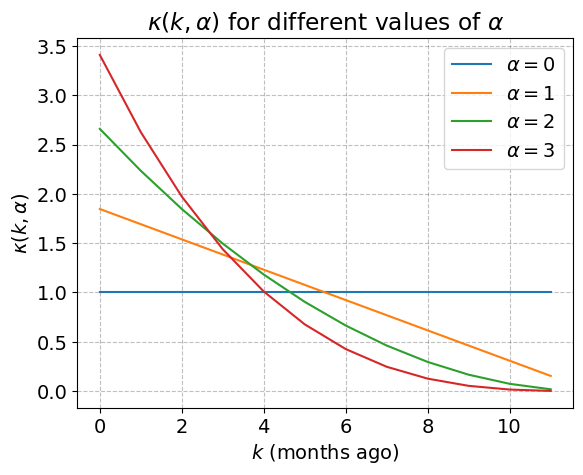

In [10]:
def kappa(k, alpha, T=12):
    numerator = (T - k)**alpha
    denominator = np.sum((T-j)**alpha for j in range(T))
    return numerator / denominator * T

T = 12
ks = np.arange(T)
alphas = [0,1,2,3]

for alpha in alphas:
    kappas = [kappa(k, alpha, T) for k in ks]
    plt.plot(ks, kappas, label=f'$\\alpha={alpha}$')
plt.xlabel(r'$k$ (months ago)')
plt.ylabel(r'$\kappa(k,\alpha)$')
plt.title(r'$\kappa(k,\alpha)$ for different values of $\alpha$')
plt.legend()
plt.show()


Now I will solve 1.2.2

In [11]:
# 1.2.2 (benyttet AI) - funktion kan ligges i dataproject.py
def pi_instantaneous(inflation_monthly, alpha, T=12):
    """
    Compute the instantaneous inflation rate from monthly inflation data.

    Parameters
    ----------
    inflation_monthly : pandas.Series
        Monthly inflation rates in percent (e.g. 0.5 means 0.5% per month).
    alpha : float
        Parameter for the weighting function κ(k, α).
        Higher α gives more weight to recent months.
    T : int, optional (default = 12)
        Number of months to include in compounding (e.g. 12 for one year).

    Returns
    -------
    pandas.Series
        Instantaneous T-month inflation rate in percent.
    """
    pi_inst = pd.Series(1.0, index=inflation_monthly.index)
    for k in range(T):
        pi_inst *= (1 + inflation_monthly.shift(k) / 100) ** kappa(k, alpha, T)
    return (pi_inst - 1) * 100

pi_inst_0 = pi_instantaneous(CPI['pi_month'], alpha=0)
assert np.allclose(pi_inst_0, CPI['pi_year'], equal_nan=True)

/var/folders/jg/t273kmdx66j20_cgz521t6d40000gn/T/ipykernel_80785/1368195693.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum((T-j)**alpha for j in range(T))


C:\Users\sebkl\AppData\Local\Temp\ipykernel_11920\1368195693.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum((T-j)**alpha for j in range(T))


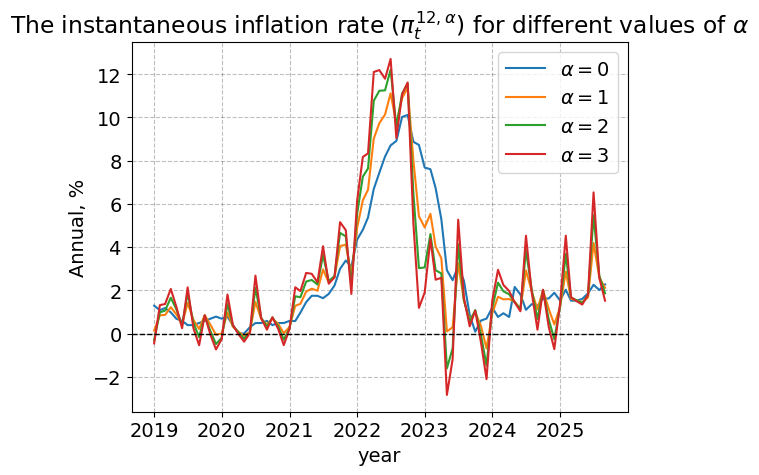

In [8]:
# 1.2.3
for alpha in alphas:
    pi_instantaneous_alpha = pi_instantaneous(CPI['pi_month'], alpha=alpha)
    plt.plot(pi_instantaneous_alpha.loc['2019':], label=f'$\\alpha={alpha}$') #linewidth=2, linestyle='--'
plt.xlabel(r'year')
plt.ylabel(r'Annual, %')
plt.title(r'The instantaneous inflation rate ($\pi_{t}^{12,\alpha}$) for different values of $\alpha$')
plt.legend()
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')
# plt.grid(True)
plt.show()

## 1.3 Core inflation

In [12]:
PRIS111 = DstApi('PRIS111') 
PRIS111.tablesummary(language='en')

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VAREGR,385,000000,"00 Consumer price index, total",151000,15.1 Overall Consumer Price Index excl. energy,False
1,ENHED,3,100,Index,300,Percentage change compared to same month the y...,False
2,Tid,297,2001M01,2001M01,2025M09,2025M09,True


In [13]:
params_PRIS111 = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': ['000000','151000','141000']},
        {'code': 'ENHED', 'values': ['100']},
        {'code': 'Tid', 'values': ['*']},
        ]
    }

In [14]:
coreCPI = PRIS111.get_data(params=params_PRIS111)

coreCPI['date'] = pd.to_datetime(coreCPI['TID'], format='%YM%m')
coreCPI['INDHOLD'] = coreCPI['INDHOLD'].astype(float)
coreCPI = coreCPI.drop(columns=['ENHED', 'TID'])

coreCPI = coreCPI.pivot_table(index='date', columns='VAREGR', values='INDHOLD')
coreCPI.columns.name = None
coreCPI = coreCPI.rename(columns={
    '00 Consumer price index, total': 'Total CPI', 
    '14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)': 'CPI ex. food and energy',
    '15.1 Overall Consumer Price Index excl. energy': 'CPI ex. energy'
})
coreCPI = coreCPI.pct_change(12)*100

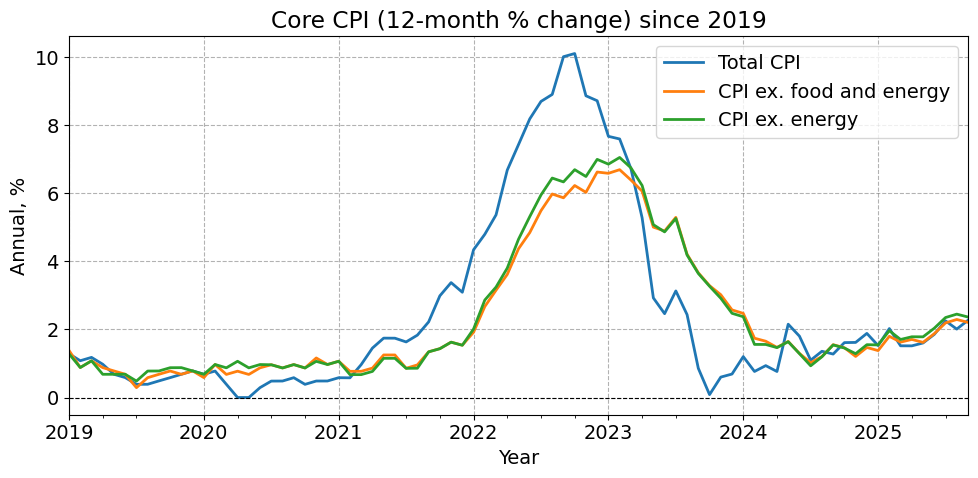

In [15]:
# Plot coreCPI (12-month % change) from 2019 onwards
ax = coreCPI.loc['2019':].plot(figsize=(10, 5), linewidth=2)
ax.set_title('Core CPI (12-month % change) since 2019')
ax.set_ylabel('Annual, %')
ax.set_xlabel('Year')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 1.4 Disaggregated inflation in Denmark

In [23]:
#1. 
levels = DstApi('PRIS111').variable_levels('VAREGR', language='en')

for row in levels.itertuples():
    print(row.id, row.text)

000000 00 Consumer price index, total
010000 01 Food and non-alcoholic beverages
011000 01.1 Food
011100 01.1.1 Bread and cereals
011110 01.1.1.1 Rice
011120 01.1.1.2 Flours and other cereals
011130 01.1.1.3 Bread
011140 01.1.1.4 Other bakery products
011150 01.1.1.5 Pizza and quiche
011160 01.1.1.6 Pasta products and couscous
011170 01.1.1.7 Breakfast cereals
011180 01.1.1.8 Other cereal products
011200 01.1.2 Meat
011210 01.1.2.1 Beef and veal
011220 01.1.2.2 Pork
011230 01.1.2.3 Lamb and goat
011240 01.1.2.4 Poultry
011260 01.1.2.6 Edible offal
011270 01.1.2.7 Dried, salted or smoked meat
011280 01.1.2.8 Other meat preparations
011300 01.1.3 Fish and seafood
011310 01.1.3.1 Fresh or chilled fish
011320 01.1.3.2 Frozen fish
011340 01.1.3.4 Frozen seafood
011350 01.1.3.5 Dried, smoked or salted fish and seafood
011360 01.1.3.6 Other preserved or processed fish and seafood-based preparations
011400 01.1.4 Milk, cheese and eggs
011410 01.1.4.1 Milk, whole, fresh
011420 01.1.4.2 Milk, lo

In [33]:
#2
PRIS111 = DstApi('PRIS111')
PRIS111.tablesummary(language='en')

params_PRIS111 = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': ['*']},
        {'code': 'ENHED', 'values': ['100']},
        {'code': 'TID', 'values': ['*']}
    ]
}

PRIS111_data = PRIS111.get_data(params=params_PRIS111)

PRIS111_data.head()

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2025-10-10T08:00:00


,VAREGR,ENHED,TID,INDHOLD
0,05.3.2.4 Toasters and grills,Index,2006M07,..
1,05.3.2.9 Other small electric household applia...,Index,2006M07,..
2,05.3.3 Repair of household appliances,Index,2006M07,67.9
3,"05.4 Glassware, tableware and household utensils",Index,2006M07,86.2
4,"05.4.0.1 Glassware, crystal-ware, ceramic ware...",Index,2006M07,..


In [34]:
print(PRIS111_data.columns.tolist())


['VAREGR', 'ENHED', 'TID', 'INDHOLD']


In [ ]:
# Convert columns
PRIS111_data['INDHOLD'] = pd.to_numeric(PRIS111_data['INDHOLD'], errors='coerce')
PRIS111_data['date'] = pd.to_datetime(PRIS111_data['TID'], format='%YM%m')

# Drop variables that is not used
PRIS111_data = PRIS111_data.drop(columns=['ENHED', 'TID'])



In [ ]:
#2. 12 month inflation rate for each group: 
PRIS111_data = PRIS111_data.sort_values(['VAREGR', 'date'])
PRIS111_data['inflation_12m'] = (
    PRIS111_data.groupby('VAREGR')['INDHOLD'].pct_change(12) * 100
)

C:\Users\HHM\AppData\Local\Temp\ipykernel_11300\1129120510.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  PRIS111_data.groupby('VAREGR')['INDHOLD'].pct_change(12) * 100


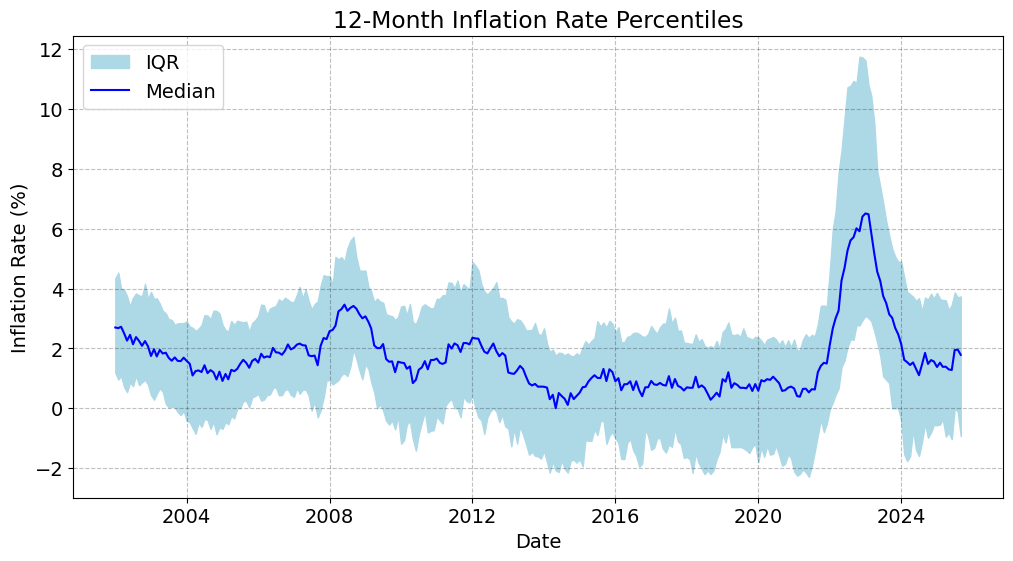

In [45]:
#2. compute using agg plot
percentiles = (
    PRIS111_data
    .groupby('date')['inflation_12m']
    .agg(
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

percentiles.head()


#plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.fill_between(percentiles['date'], percentiles['p25'], percentiles['p75'], color='lightblue', label='IQR')
plt.plot(percentiles['date'], percentiles['p50'], color='blue', label='Median')
plt.title('12-Month Inflation Rate Percentiles')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()




The figure above shows the distribution of 12-month inflation rates for the 4-digit product categories. The blue line represents the median inflation, and the light blue area
shows the interquartile which is 25th to 75th percentile. This shows how much inflation varies across the different products, more specifically across different price ranges. 
The figure shows that for the majority of the period from 2000 to 2010, inflation rates were relatively stable, around 2%.
However, the figure also indicates that there were noticable peaks in 2021-2023 for certain product groups, indicating that some products experienced higher inflation. 
Product groups that were more affected during this period was for example energy and food products. 


In [47]:
#Opg 3. 
# Select August 2020 and August 2025
subset = PRIS111_data[PRIS111_data['date'].isin(['2020-08-01', '2025-08-01'])]

# Each group should have both months: 
pivot = subset.pivot(index='VAREGR', columns='date', values='INDHOLD')

#  The 5-year percent change:
pivot['change_2020_2025'] = (pivot['2025-08-01'] / pivot['2020-08-01'] - 1) * 100

# Drop categories with missing data
pivot = pivot.dropna(subset=['change_2020_2025'])

C:\Users\HHM\AppData\Local\Temp\ipykernel_11300\145509684.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  subset = PRIS111_data[PRIS111_data['date'].isin(['2020-08-01', '2025-08-01'])]


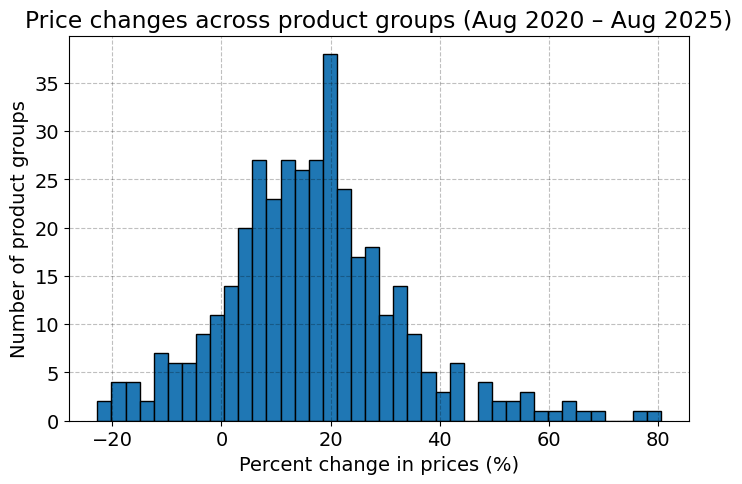

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(pivot['change_2020_2025'], bins=40, edgecolor='black')
plt.title('Price changes across product groups (Aug 2020 – Aug 2025)')
plt.xlabel('Percent change in prices (%)')
plt.ylabel('Number of product groups')
plt.show()



The histogram above shows how 12-month price changes across all 4-digit product categories has changed from August 2020 to August 2025. 
It appears, that most product categories experienced price increases between approx. 5 % - 25 %, whereas only a few saw large decreases or very high increases above 50 %. 
This indicates that inflation during this period was broad but moderate, however some product categories showed more variation in inflation.
This could indicate, that specific product groups, probably food and energy, experienced much higher inflation pressure.  

In [51]:
#assignment 4. 
#sort: 
sorted_changes = pivot.sort_values('change_2020_2025', ascending=False)

# top 10 and bottom 10
top10 = sorted_changes.head(10)
bottom10 = sorted_changes.tail(10)

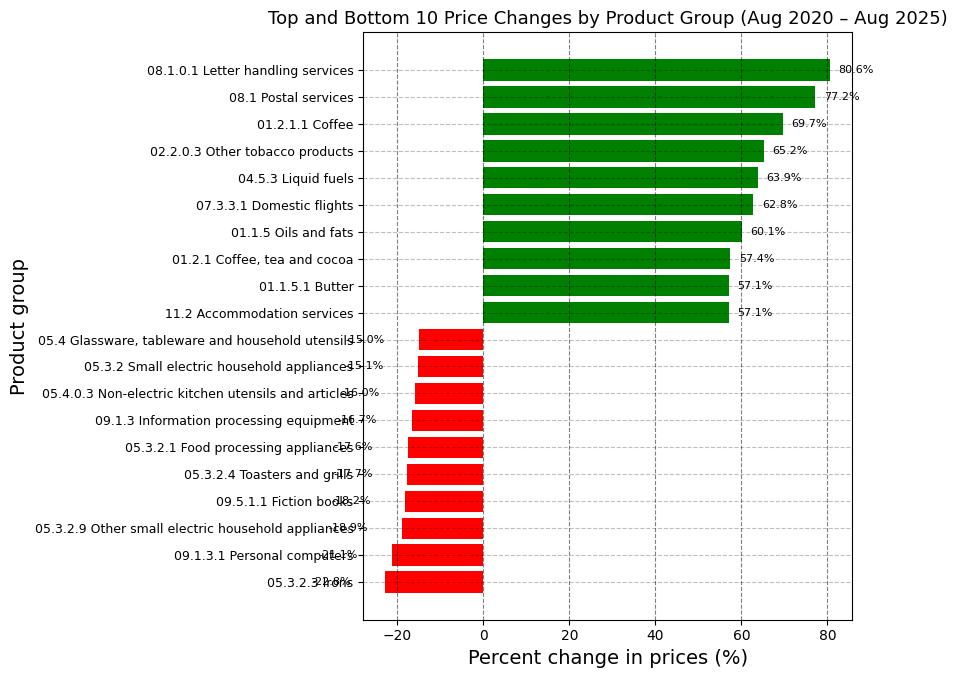

In [61]:
topbottom_sorted.index = topbottom_sorted.index.str.replace(r'^\d+\.\d+\.\d+\.\d+\s*', '', regex=True)

plt.figure(figsize=(9,7))
topbottom_sorted = topbottom.sort_values('change_2020_2025')

bars = plt.barh(topbottom_sorted.index, topbottom_sorted['change_2020_2025'],
                color=['red' if x < 0 else 'green' for x in topbottom_sorted['change_2020_2025']])

plt.title('Top and Bottom 10 Price Changes by Product Group (Aug 2020 – Aug 2025)', fontsize=13)
plt.xlabel('Percent change in prices (%)')
plt.ylabel('Product group')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.grid(axis='x', linestyle='--', alpha=0.5)

for bar in bars:
    plt.text(bar.get_width() + (2 if bar.get_width() > 0 else -8),
             bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%",
             va='center', ha='left' if bar.get_width() > 0 else 'right',
             fontsize=8)

plt.tight_layout()
plt.show()

# 2 International Comparison

In [ ]:
# Convert columns
PRIS111_data['INDHOLD'] = pd.to_numeric(PRIS111_data['INDHOLD'], errors='coerce')
PRIS111_data['date'] = pd.to_datetime(PRIS111_data['TID'], format='%YM%m')

# Drop variables that is not used
PRIS111_data = PRIS111_data.drop(columns=['ENHED', 'TID'])



In [16]:
### Erstat med egen API-nøgle fra FRED og lokal txt-fil placering
# with open('/Users/macbook/Desktop/4 semester - 11. semester/Programming for Economists /fredapi.txt', 'r') as f: fred_api_key = f.read()
with open('C:/Users/sebkl/OneDrive/Uni/Kandidat/Programming for economist/fredapi.txt', 'r') as f: fred_api_key = f.read()
fred = Fred(api_key=fred_api_key)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/sebkl/OneDrive/Uni/Kandidat/Programming for economist/fredapi.txt'

## 2.1 CPI vs HICP

We now wish to compare the CPI from Denmark Statistic with the Harmonized Index for Consumer Prices (HICP). 

* CPI is national measure, which reflect the cunsumption pattern of Danish residents.

* HICP is a cross-country comparable index following standardized methods set by Eurostat, such that inflation can be compared across countries.

E.g. a difference between the two indices is the inclusion of owner-occupied housing, which is the costs associated with owning a home and is excluded in the HICP.

<Axes: title={'center': 'CPI vs HICP for Denmark'}, xlabel='Year', ylabel='Index, 2020=100'>

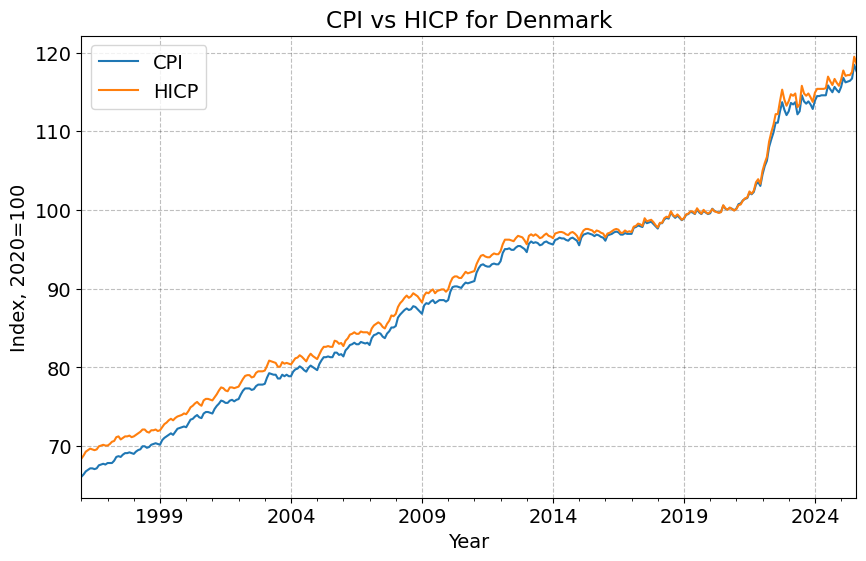

In [14]:
HICP = fred.get_series('CP0000DKM086NEST')
HICP.name = 'HICP'
HICP = HICP/HICP[HICP.index.year == 2020].mean()*100

CPIvsHICP = pd.DataFrame({'CPI': CPI['index'], 'HICP': HICP}).dropna()
CPIvsHICP.plot(title='CPI vs HICP for Denmark', ylabel='Index, 2020=100', xlabel='Year', figsize=(10,6))

The methodology of the two indexes does exhibit similiar trends. Interestingly, the HICP has generally shown lower inflation prior to 2020, reflected by its lower slope, but slightly higher inflation since then

## 2.2 Across countries

Using the FRED API we extract HICP (All Items) series for Denmark, Austria, the Euro Area and the United States respectively for a cross country comparison of the annual inflation rate.

<Axes: title={'center': '12-Month HICP Inflation Rate'}, xlabel='Year', ylabel='Annual, %'>

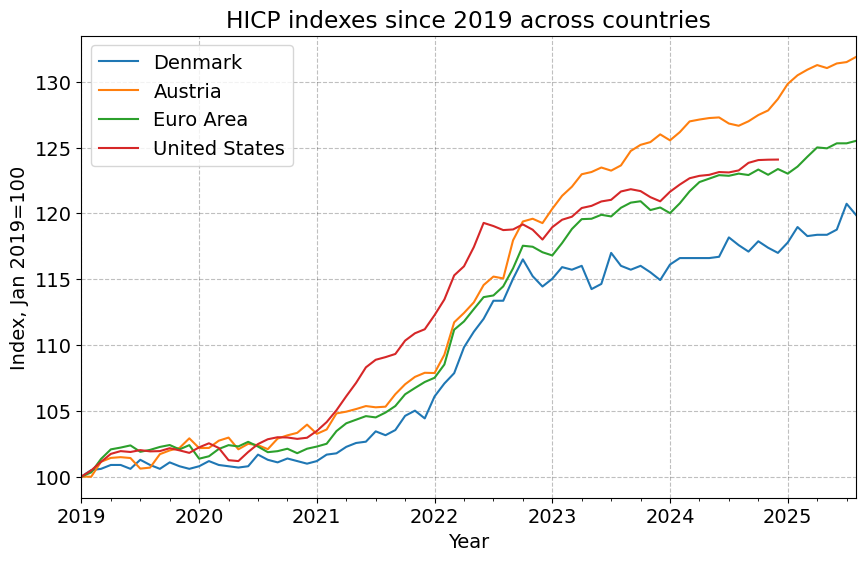

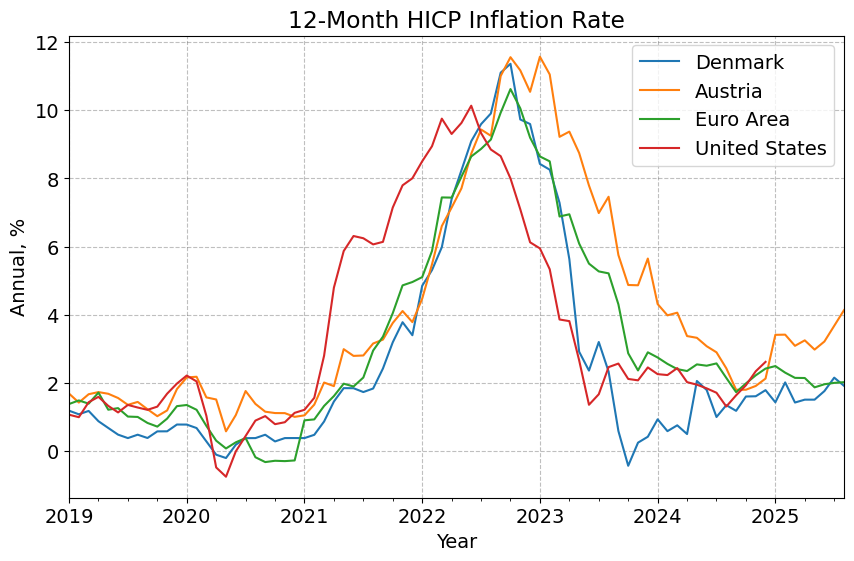

In [56]:
HICP_series = {
     "CP0000DKM086NEST":"Denmark",
     "CP0000ATM086NEST":"Austria",
     "CP0000EZ19M086NEST":"Euro Area",
     "CP0000USM086NEST":"United States",
}

HICP_indexes = {}
for code,name in HICP_series.items():
    var = fred.get_series(code)
    var.name = name
    HICP_indexes[name] = var

HICP_indexes = pd.DataFrame(HICP_indexes)
HICP_indexes = HICP_indexes/HICP_indexes.loc["2019-01-01"]*100
HICP_indexes.loc['2019':'2025-08-01'].plot(figsize=(10,6), 
                                           xlabel='Year', 
                                           ylabel='Index, Jan 2019=100', 
                                           title='HICP indexes since 2019 across countries'
                                           )

HICP_inflation = HICP_indexes.pct_change(12, fill_method=None) * 100
HICP_inflation.loc['2019':'2025-08-01'].plot(figsize=(10,6),
                                             title="12-Month HICP Inflation Rate", 
                                             ylabel='Annual, %', 
                                             xlabel='Year'
                                             )

Generally, the plots show that all the regions have seen similar inflation paths since 2019. Austria has as of August 2025 experienced the biggest rise in prices. In contrast, Denmark has seen the lowest rise in prices over the same period. The inflation resurgence in United States led the Euro Area countries, seeing rising prices before the trend in Europe. Both the Euro Area and the United States have experienced similar overall inflation up to end-of-year 2024 (the last available datapoint for USA).

In [82]:
summary_HICP = HICP_inflation.resample('Y').agg(['mean', 'min', 'max'])
summary_HICP.index = summary_HICP.index.year
summary_HICP.round(2).loc["2019":]

C:\Users\sebkl\AppData\Local\Temp\ipykernel_11920\3347740674.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  summary_HICP = HICP_inflation.resample('Y').agg(['mean', 'min', 'max'])


Denmark              Austria              Euro Area               \
        mean   min    max    mean   min    max      mean   min    max   
2019    0.73  0.39   1.19    1.49  1.03   1.83      1.20  0.73   1.72   
2020    0.33 -0.19   0.79    1.39  0.59   2.19      0.26 -0.31   1.36   
2021    1.94  0.39   3.79    2.76  1.06   4.11      2.59  0.91   4.96   
2022    8.51  4.85  11.36    8.59  4.48  11.55      8.36  5.11  10.62   
2023    3.44 -0.42   8.43    7.78  4.87  11.57      5.46  2.37   8.64   
2024    1.27  0.51   2.06    2.93  1.81   4.32      2.36  1.74   2.75   
2025    1.72  1.43   2.16    3.40  2.98   4.14      2.12  1.88   2.50   

     United States               
              mean   min    max  
2019          1.37  1.00   1.99  
2020          0.77 -0.74   2.22  
2021          5.33  1.22   8.01  
2022          8.69  6.13  10.13  
2023          3.03  1.37   5.95  
2024          2.03  1.32   2.62  
2025           NaN   NaN    NaN

In [79]:
print("Summary statistics for HICP inflation from 2019 to 2024:")
HICP_inflation.loc["2019":"2024"].describe().loc[['mean', 'min', 'max']].round(2)

Summary statistics for HICP inflation from 2019 to 2024:


,Denmark,Austria,Euro Area,United States
mean,2.71,4.16,3.37,3.54
min,-0.42,0.59,-0.31,-0.74
max,11.36,11.57,10.62,10.13


# 3 Extension

We find that that ...